# Classification Problems

#### In this notebook, we explore 3 real-world classification problems:
1. **Spotify Songs Dataset**: will a user like a song or not based on its features?
2. **Adult Census Dataset**: will a person make more or less than 50K per year based on their features?
3. **Trump Tweets Dataset**: will a Trump tweet go viral based on its text content?

#### We will explore several classification models:
1. decision tree
2. k-nearest neighbor
3. SVC with RBF kernel
4. logistic regression

#### We also use column transformers to create preprocessing pipelines.

In [1]:
import hashlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split, 
    GridSearchCV
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def my_sha1(text):
    return hashlib.sha1(text.encode("utf-8")).hexdigest()

# Spotify Songs Dataset
We'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). 

## Exploratory Data Analysis (EDA)

In [2]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)

# split the data into training and test sets
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)

In [3]:
spotify_summary = train_df.describe()
spotify_summary

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [4]:
range = spotify_summary.max() - spotify_summary.min()
largest_range_feature = range.idxmax()
largest_range_feature
# duration appears to have the largest range.

'duration_ms'

Plot histograms of features in the `0` and `1` category.

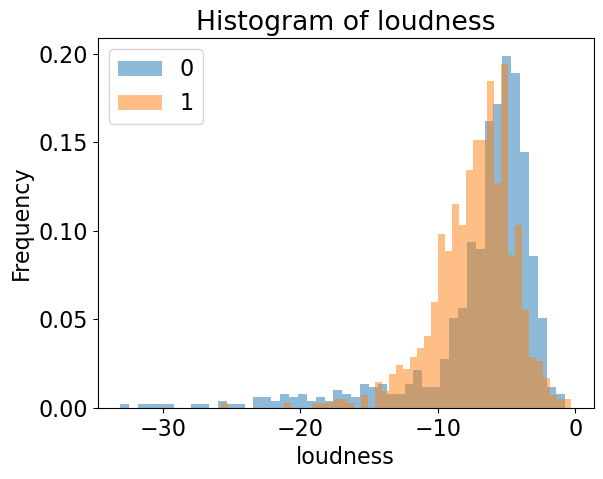

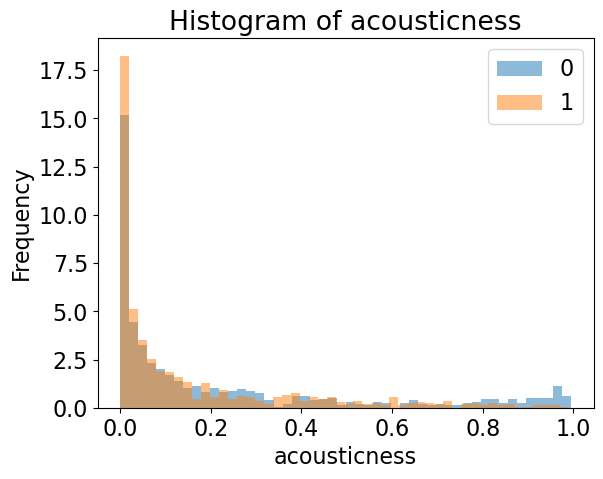

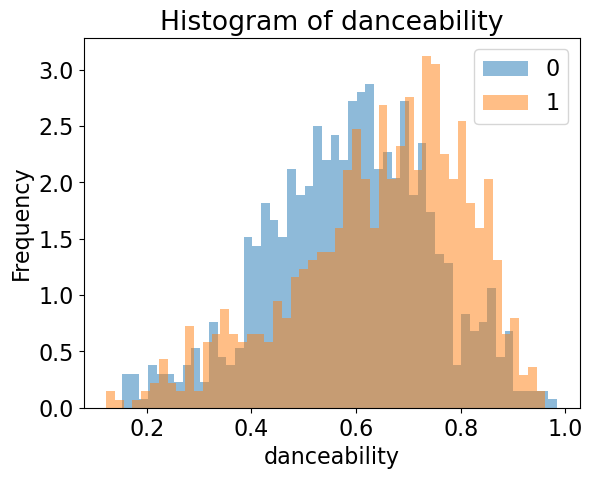

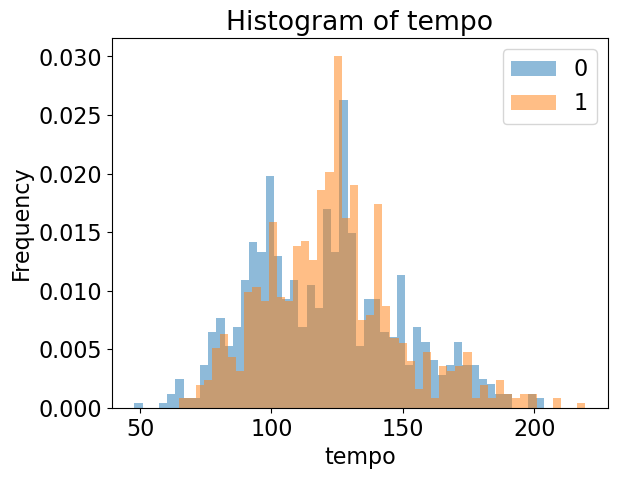

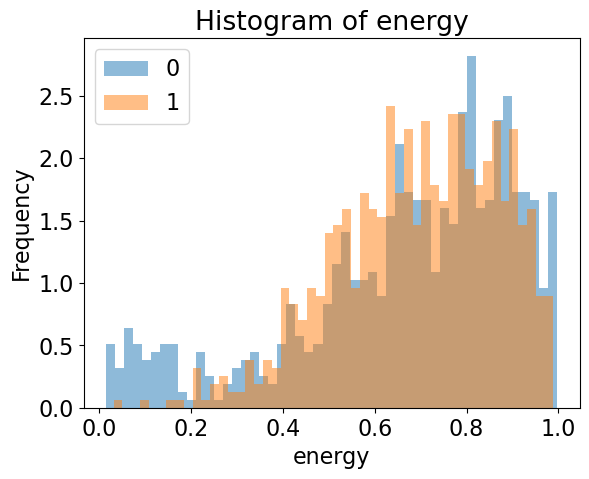

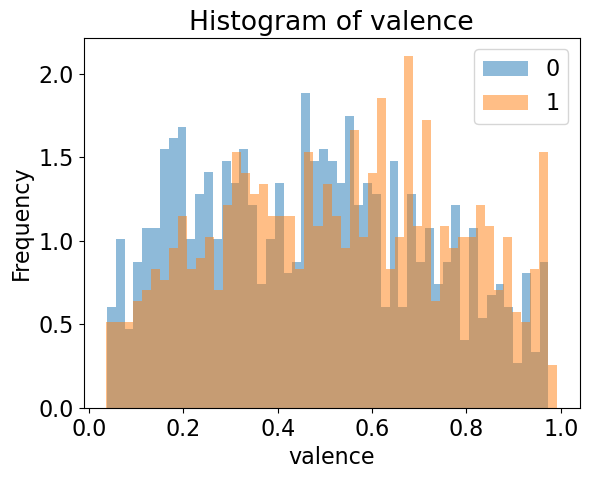

In [5]:
features = ["loudness", "acousticness", "danceability", "tempo", "energy", "valence"]
for feature in features:
    feat = feature
    train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
    plt.xlabel(feat)
    plt.show()

### Notes:
- Even if the histograms of a feature are identical for both classes, the feature may still be useful in predicting the target class. A tree would split data on this feature among many other features: we do not know how samples with the same feature value in both classes would split on other features. The class clusters occurring at identical frequencies across this one feature does not define each of the samples' other features.
- Some features may more suitable for analysis than others. From personal experience, song artist is likely to predict whether a user likes a song: music fans tend to listen to an artist's entire discography. Song title, on the other hand, does not usually predict my song preferences.
- There are challenges with using certain features in our analysis. Song title and artist are categorical, non-numerical variables: we cannot easily create decision boundaries on these features using our current binary decision tree model.

## Model Building

In [6]:
X_train = train_df.drop(["target", "song_title", "artist"], axis=1)
y_train = train_df["target"]
X_test = test_df.drop(["target", "song_title", "artist"], axis=1)
y_test = test_df["target"]

Carry out 10-fold cross-validation using `DummyClassifier` with `random_state=123`.

In [7]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(random_state=123)
dummy_score = np.mean(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True)["test_score"]).item()
dummy_score

0.5077524729698643

Create a `DecisionTreeClassifier` with `random_state=123` and store it in a variable called `spotify_tree`.

In [8]:
spotify_tree = DecisionTreeClassifier(random_state=123)

Carry out 10-fold cross validation with the `spotify_tree` object above using `cross_validate` on `X_train` and `y_train`.

In [9]:
dt_scores_df = pd.DataFrame(cross_validate(spotify_tree, X_train, y_train, cv=10, return_train_score=True))
dt_scores_df

,fit_time,score_time,test_score,train_score
0,0.065977,0.007002,0.697531,0.999311
1,0.042000,0.006023,0.660494,1.000000
2,0.028001,0.004019,0.685185,0.999311
3,0.026995,0.008014,0.639752,1.000000
4,0.029005,0.002997,0.639752,0.999311
5,0.028003,0.002996,0.658385,0.999311
6,0.028009,0.001993,0.639752,0.999311
7,0.030000,0.002004,0.608696,0.999311
8,0.028018,0.001981,0.701863,0.999311
9,0.024997,0.002002,0.695652,0.999311


### Notes:
- I trust that the test score is 0.6-0.7, based on the variance across the 10 folds of cross-validation. Cross-validation ensures that there is no sampling bias in the validation set._
- The train score is almost 1, while the test score is ~0.6. This suggests that our model is overfitting to the training data._

## Hyperparameter Tuning

Evaluate decision tree model accuracy over a range of max depths.

In [10]:
depths = np.arange(1, 25, 2)
depths

results = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=123)
    scores = cross_validate(tree, X_train, y_train, cv=10, return_train_score=True)
    mean_train_score = np.mean(scores["train_score"])
    mean_test_score = np.mean(scores["test_score"])
    results.append({"max_depth": depth, "mean_train_accuracy": mean_train_score, "mean_test_accuracy": mean_test_score})
results_df = pd.DataFrame(results)
results_df.set_index("max_depth", inplace=True)

results_df

,mean_train_accuracy,mean_test_accuracy
max_depth,,
1,0.651030,0.646032
3,0.733485,0.692524
5,0.794035,0.711713
7,0.858718,0.703060
9,0.912930,0.690610
11,0.955157,0.680048
13,0.980850,0.674457
15,0.993525,0.658979
17,0.998278,0.669538


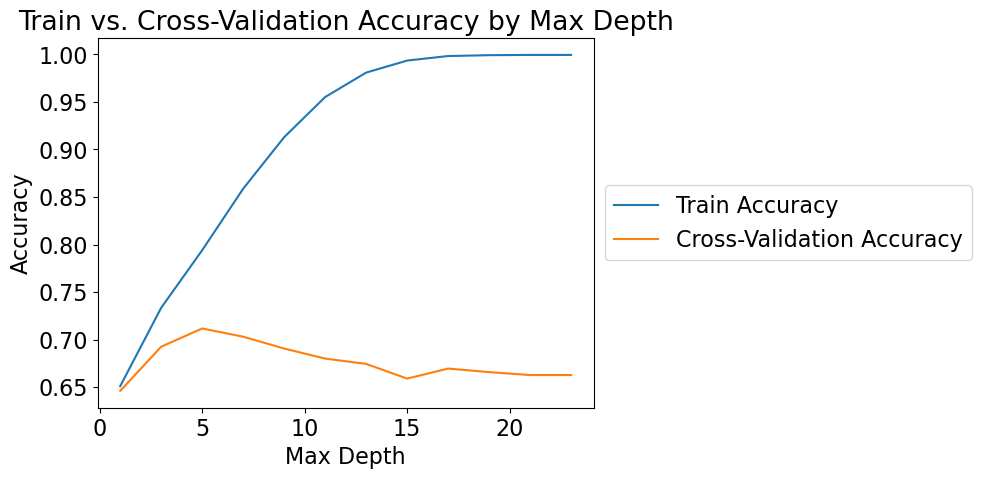

In [11]:
plt.plot(results_df.index, results_df["mean_train_accuracy"], label="Train Accuracy")
plt.plot(results_df.index, results_df["mean_test_accuracy"], label="Cross-Validation Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Train vs. Cross-Validation Accuracy by Max Depth")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

As max depth increases:
1. Train accuracy increases.
2. The difference between train and cross-validation accuracy increases.

The best max depth is 5, where cross-validation accuracy peaks.

## Final Model Evaluation

1. Create a decision tree model `best_model` using the `best_max_depth` you chose in the previous exercise with `random_state=123`. 
2. Fit the `best_model` on the _entire training set_ (`X_train` and `y_train`). 
3. Compute the test score (on `X_test` and `y_test`) and store it in a variable called `test_score` below. 

In [12]:
best_model = DecisionTreeClassifier(max_depth=5, random_state=123)
best_model.fit(X_train, y_train)
test_score = best_model.score(X_test, y_test)
test_score

0.7178217821782178

### Notes:
- The test and cross-validation scores are comparable: around 0.72 accuracy.
- If you simply chose the max depth that provided the best accuracy on the training data, you would choose the highest depth possible and overfit your model. An overfitted model has lower validation accuracy than an ideal model, and learns unreliable patterns which do not accurately predict the target.
- The max depth we chose for this user would not necessarily generalize to other users: certain users may be more heavily influenced by different features.

# Adult Census Dataset
You will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

## EDA

In [13]:
census_df = pd.read_csv("data/adult.csv")

train_df, test_df = train_test_split(census_df, test_size=0.6, random_state=123)

In [14]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [15]:
# replace ? with NaN
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)

In [16]:
census_summary = train_df.describe(include="all")
census_summary

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,13024.000000,12284,1.302400e+04,13024,13024.000000,13024,12281,13024,13024,13024,13024.000000,13024.000000,13024.000000,12783,13024
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,9123,NaN,4153,NaN,5936,1649,5195,11158,8700,NaN,NaN,NaN,11717,9875
mean,38.546913,NaN,1.884759e+05,NaN,10.057432,NaN,NaN,NaN,NaN,NaN,1079.831695,86.543074,40.395654,NaN,NaN
std,13.610225,NaN,1.040895e+05,NaN,2.553084,NaN,NaN,NaN,NaN,NaN,7322.034546,403.025863,12.285347,NaN,NaN
min,17.000000,NaN,1.376900e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.170962e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778990e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.365655e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


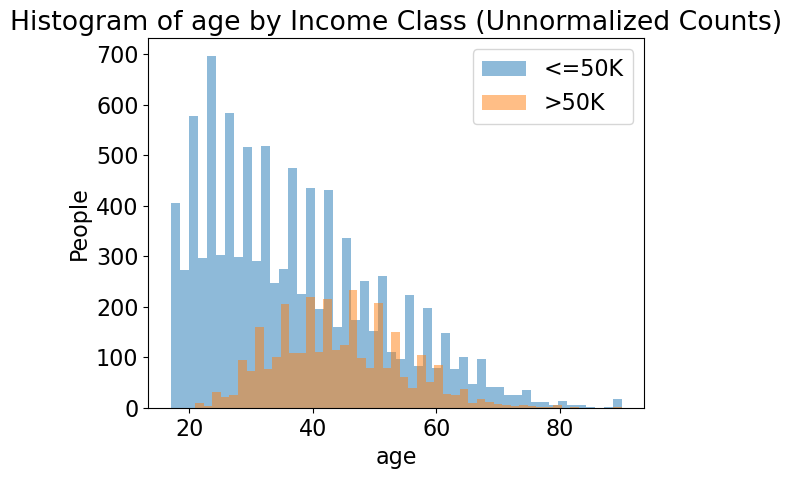

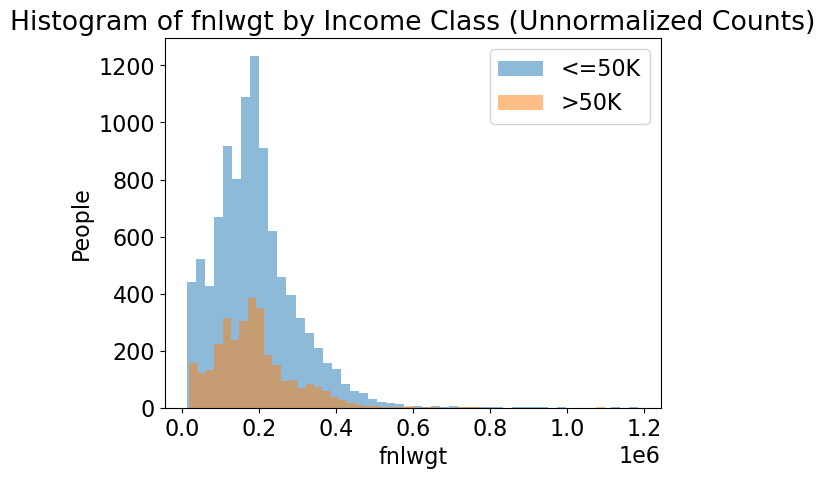

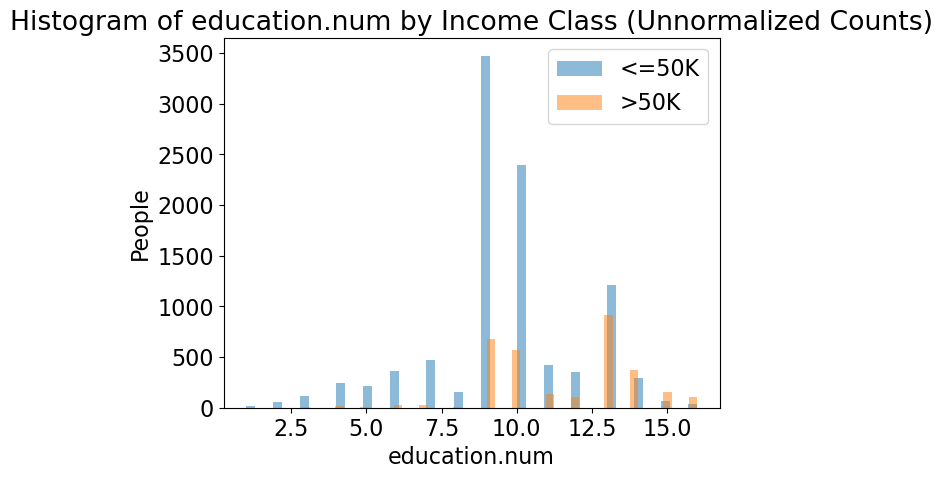

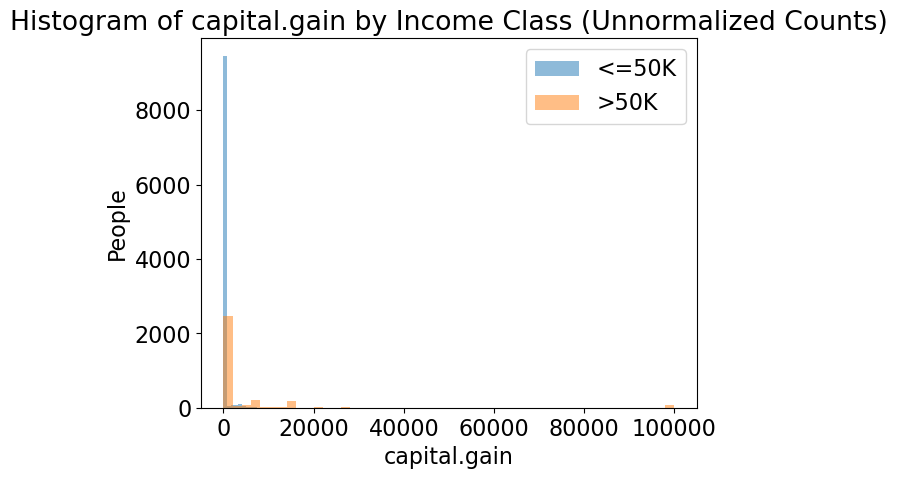

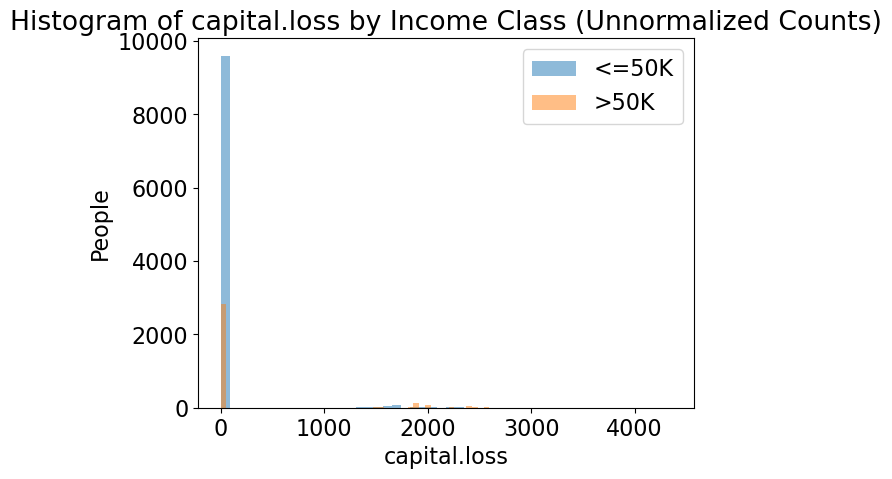

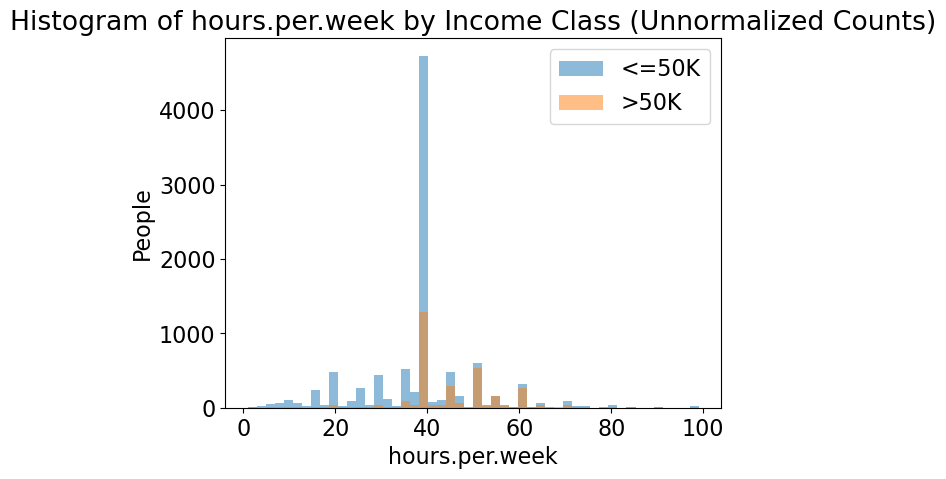

In [17]:
# train_df.dtypes
numeric_cols = list(train_df.select_dtypes(include=['number']).columns)

for col in numeric_cols:
    train_df.groupby("income")[col].plot.hist(bins=50, alpha=0.5, legend=True, density=False, title = "Histogram of " + col + " by Income Class (Unnormalized Counts)");
    plt.ylabel("People")
    plt.xlabel(col)
    plt.legend()
    plt.show()

### Observations:
- Age: The majority of people earn <=50K, and the minority that earn >50K are older.
- Capital gain/loss: the vast majority of people have 0 gain/loss, and a small amount of people in the >50K category have higher capital gains.
- Education: education.num is a categorical feature, the majority of people have an education level of 9-10 (whatever that means), and people in the >50K category tend to have a higher education level.
- fnlwgt: the means of both populations are centered around 0.2 (whatever that means).
- Hours per week: the majority of people work 40 hours per week, and people in the >50K category tend to work >40 hours.

## Column Transformers

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling with `StandardScaler` |  A numeric feature with no missing values, ranging from 17 to 90. Scaling is recommended due to its distinct range compared to other numeric features. While MinMaxScaler might be more suitable, using StandardScaler should be fine too.|
| workclass | imputation, one-hot encoding | This feature requires imputation for missing values, and one-hot encoding because it is a nominal (unordered) categorical variable. |
| fnlwgt | drop | Unclear what this feature even represents (final weight?) - dropping it from the data. Likely not relevant to the target. |
| education | ordinal encoding | This feature has an intrinsic order (low to high education level). |
| education.num | drop | This is the numerical version of education level (but ordinal encoding is not known), which will be encoded in the feature above. |
| marital.status | one-hot encoding  | This feature is a nominal (unordered) categorical variable. |
| occupation | imputation, one-hot encoding  | This feature requires imputation for missing values, and one-hot encoding because it is a nominal (unordered) categorical variable. |
| relationship | one-hot encoding  | This feature is a nominal (unordered) categorical variable. |
| race | drop  | We know that socioeconomic status is influenced by race due to systemic racism, however we do not want to introduce this bias into the model. |
| sex | one-hot encoding with "binary=True" | This feature is a nominal (unordered) categorical variable. |
| capital.gain | scaling with `StandardScaler` | Scaling is recommended due to its distinct range compared to other numeric features (0-99999). | 
| capital.loss | scaling with `StandardScaler` | Scaling is recommended due to its distinct range compared to other numeric features (0-4356). |
| hours.per.week | scaling with `StandardScaler` | Scaling is recommended due to its distinct range compared to other numeric features (1-99). |
| native.country | imputation, one-hot encoding | This feature requires imputation for missing values, and one-hot encoding because it is a nominal (unordered) categorical variable. | 	

Sort the features according to what preprocessing should be performed.

In [18]:
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = ["workclass", "marital.status", "occupation", "relationship", "native.country"]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "education.num", "race"]
target = "income"

Carry out 5-fold cross-validation using [`scikit-learn`'s `cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function.

In [19]:
X_train = train_df.drop(columns=["income"])
y_train = train_df["income"]
X_test = test_df.drop(columns=["income"])
y_test = test_df["income"]

In [20]:
model = DummyClassifier()
cv = cross_validate(model, X_train, y_train, cv=5, return_train_score=True)
dummy_df = pd.DataFrame(cv)
dummy_df

,fit_time,score_time,test_score,train_score
0,0.014999,0.006999,0.758157,0.758230
1,0.015000,0.006998,0.758157,0.758230
2,0.013994,0.005001,0.758157,0.758230
3,0.006999,0.003000,0.758157,0.758230
4,0.006998,0.003001,0.758449,0.758157


We cannot simply train the SVC model using our current training data: SVC requires numerical features to be scaled, categorical features (and the target) to be encoded, and imputation to be done on null values. Additionally, we usually want to tune C and gamma during cross-validation, which we did not do above.

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. First, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer` using `make_column_transformer`.

In [21]:
numeric_transformer = StandardScaler()

# X_train["education"].unique()
education_levels = ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th", "HS-grad", "Prof-school", "Assoc-voc", "Assoc-acdm", "Some-college", "Bachelors", "Masters", "Doctorate"]
ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

binary_transformer = OneHotEncoder(drop="if_binary", dtype=int, sparse_output=False)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

In [22]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),  
    (ordinal_transformer, ordinal_features), 
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [23]:
transformed_df = preprocessor.fit_transform(X_train)

### Notes:
- We can't simply call `fit_transform` on our test data with `StandardScaler`. This violates the Golden Rule by leaking test data: the test data should be scaled using the scale developed from the training data alone, and we would see test set statistics (mean/sd) during `fit_transform`.
- If you don't follow the Golden Rule, your model will be shaped by test data and it will be overfit to the data during training. Thus, the resulting test score will likely be higher than the true accuracy of the model.
    - It's only okay to violate the Golden Rule when looking at columns with a fixed number of categories, since we know the categories in advance.
- There are advantages to using pipelines: they reduce time and human error by automating transformations, and avoid data leakage by ensuring transformations are only fit on training data before applying them to both training and test data.
- It is appropriate to use sklearn `ColumnTransformer` when you have features that require different preprocessing steps (eg. numerical and categorical features).

## Cross-Validating Models

In [24]:
results_dict = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    # Run cross-validation
    scores = cross_validate(model, X_train, y_train, **kwargs)
    df_scores = pd.DataFrame(scores)

    mean_scores = df_scores.apply(np.mean, axis=0)
    std_scores = df_scores.apply(np.std, axis=0)

    formatted = mean_scores.combine(std_scores, 
                                     lambda m, s: f"{m:.3f} (+/- {s:.3f})")
    
    return formatted

Cross-validate using your generated preprocessing pipeline.

In [25]:
dummy = DummyClassifier(random_state = 123)

pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)

In [26]:
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.058 (+/- 0.018),0.018 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)


Now test several different models.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

In [28]:
results = {}

for model in models:
    pipe = make_pipeline(preprocessor, models[model])
    results[model] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)

In [29]:
income_pred_results_df = pd.DataFrame(results).T
income_pred_results_df

,fit_time,score_time,test_score,train_score
decision tree,0.203 (+/- 0.029),0.031 (+/- 0.008),0.817 (+/- 0.006),0.987 (+/- 0.000)
kNN,0.058 (+/- 0.009),0.251 (+/- 0.119),0.836 (+/- 0.007),0.883 (+/- 0.002)
RBF SVM,5.688 (+/- 0.538),1.697 (+/- 0.116),0.852 (+/- 0.004),0.855 (+/- 0.002)


### Notes:
- The SVM (SVC with RBF kernel) model has the highest validation accuracy.
- The kNN model has the shortest fit time, and the decision tree has the shortest score time.
- Given the difference between the test/train scores, the decision tree model shows the highest degree of overfitting (largest difference), and the SVM model exhibits the least overfitting (smallest difference).

## Hyperparameter Tuning

Carry out hyperparameter optimization for the hyperparameter `C` of the SVC RBF classifier. 

In [30]:
param_grid = {"C": np.logspace(-1, 2, 4)}
param_grid

c_values = np.logspace(-1, 2, 4)

for c in c_values:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", SVC(C=c))])
    results_dict[c] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
    
c_results_df = pd.DataFrame(results_dict).T
c_results_df

,fit_time,score_time,test_score,train_score
dummy,0.058 (+/- 0.018),0.018 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)
0.1,6.991 (+/- 0.724),2.220 (+/- 0.548),0.838 (+/- 0.006),0.838 (+/- 0.001)
1.0,5.268 (+/- 0.670),1.633 (+/- 0.242),0.852 (+/- 0.004),0.855 (+/- 0.002)
10.0,4.959 (+/- 0.102),1.334 (+/- 0.012),0.858 (+/- 0.004),0.862 (+/- 0.001)
100.0,6.608 (+/- 0.196),1.456 (+/- 0.296),0.860 (+/- 0.005),0.871 (+/- 0.002)


The best value for C is 100.

## Final Model Evaluation

In [31]:
final_pipeline = make_pipeline(
   preprocessor, 
   SVC(kernel='rbf', C=100, random_state=123)
)
final_pipeline.fit(X_train, y_train)
test_score = final_pipeline.score(X_test, y_test)

In [32]:
test_score

0.8497722270563546

# Trump Tweets Dataset
We'll be working with a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets. To make predictions, we'll be using only the content (text) of the tweet. 

In [33]:
tweets_df = pd.read_csv("data/realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [34]:
y = tweets_df["retweets"] > 10_000
X = tweets_df["content"]

In [35]:
# splits the features and target into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6, random_state=123
)

# create the CountVectorizer object, which will convert the tweets to a matrix of word counts
countvec = CountVectorizer(stop_words="english")

# creates the logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=123)

## Baseline

In [36]:
dummy = DummyClassifier(random_state=123)

pipe_dummy = make_pipeline(countvec, dummy)

dummy_cv_score = cross_val_score(pipe_dummy, X_train, y_train).mean()
dummy_cv_score

0.7423875432525952

## Cross-Validation

In [37]:
# creates a pipeline that contains our CountVectorizer and logistic regression model
pipe = make_pipeline(countvec, lr)

# calculates the mean cross-validation score for our logistic regression model
cv_score = cross_val_score(pipe, X_train, y_train).mean()
cv_score

0.8953863898500576

Above we averaged the scores from the 5 folds of cross-validation of logistic regression. Print out the 5 individual scores.

In [38]:
cv_scores = cross_val_score(pipe, X_train, y_train)
cv_scores

array([0.89186851, 0.90023068, 0.89561707, 0.88956171, 0.89965398])

### Notes:
- Logistic regression (89.5%) has more than a 15% higher validation score than the dummy classifier (74.2%).
- All the cross-validation scores seem relatively close together: they only vary by 1-2% from the mean.
- The tweets dataset (43352 samples) is much larger than the [the cities dataset](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/lectures/data/canada_usa_cities.csv) (only 209 samples) - this reduces the variance in cross-validation scores, as it reduces the probability of non-representative sampling during the validation data split.

## Training Model

In [39]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000, random_state=123),
)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

## Making Predictions

Using this model, find the tweet in the test set with the highest predicted probability of being viral.

In [40]:
positive_predictions = pipe_lr.predict_proba(X_test)[:, 1]
max_idx = pd.Series(positive_predictions).idxmax()

tweet = X_test.iloc[max_idx]
tweet

'There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?'

In [41]:
prob = positive_predictions[max_idx]
prob

0.9999999830416225

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `Pipeline` object as follows:

In [42]:
vec_from_pipe = pipe_lr.named_steps["countvectorizer"]
lr_from_pipe = pipe_lr.named_steps["logisticregression"]

Using these extracted components above, get the five words with the highest coefficients and 5 words with smallest coefficients.

In [43]:
coef_df = pd.DataFrame({"Word": vec_from_pipe.get_feature_names_out(), "Coefficient": lr_from_pipe.coef_[0]})
sorted_coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

In [44]:
top_5_words = sorted_coef_df.head(5)["Word"].tolist()
top_5_words

['democrats', 'transcripts', 'harassment', 'coronavirus', 'fake']

In [45]:
bottom_5_words = sorted_coef_df.tail(5)["Word"].tolist()
bottom_5_words

['thanks', 'donaldtrump', 'trump2016pic', 'barackobama', 'realdonaldtrump']

## Hyperparameter Optimization

#### 1. Optimize the `max_features` of `CountVectorizer`.

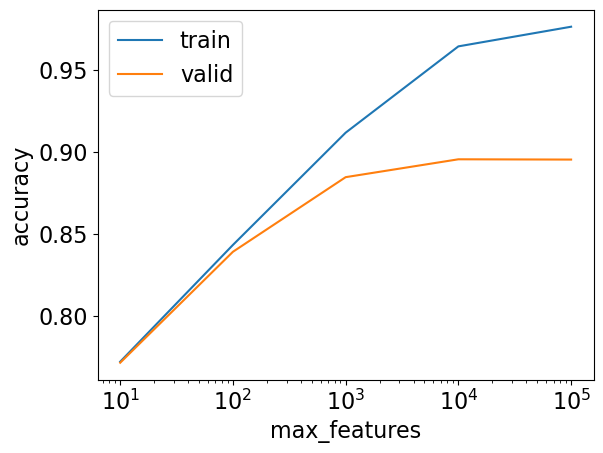

In [46]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000, random_state=123),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [47]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.772131,0.771511
1,100,0.843339,0.839158
2,1000,0.911794,0.884660
3,10000,0.964418,0.895559
4,100000,0.976399,0.895386


I would choose `max_features`=100000, since this maximizes the cross-validation accuracy.

#### 2. Optimize the `C` of `LogisticRegression`.

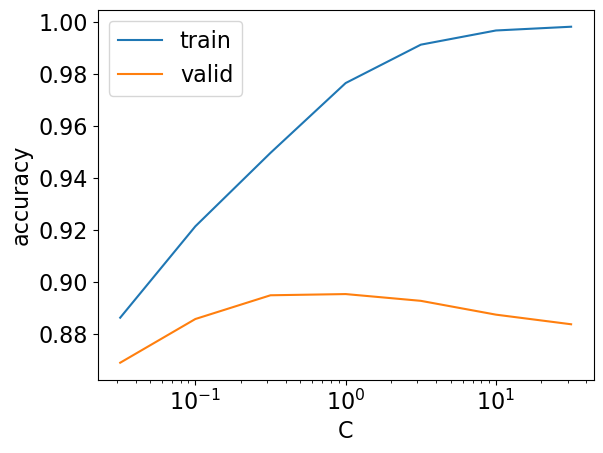

In [48]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english"),
        LogisticRegression(max_iter=1000, C=C, random_state=123),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [49]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.886318,0.869031
1,0.100000,0.921396,0.885813
2,0.316228,0.949596,0.894925
3,1.000000,0.976399,0.895386
4,3.162278,0.991133,0.892791
5,10.000000,0.996583,0.887486
6,31.622777,0.998025,0.883795


I would choose `C`=1.0, since cross-validation accuracy peaks at this value.

#### 3. Optimize the combination of both `max_features` and `C` using a grid search.

In [50]:
param_grid = {
    "countvectorizer__max_features": [10, 100, 1000, 10_000, 100_000],
    "logisticregression__C": 10.0 ** np.arange(-1.5, 2, 0.5)
}
grid_search = GridSearchCV(pipe_lr, param_grid = param_grid, n_jobs=-1, return_train_score=True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'countvectorizer__max_features': 10000, 'logisticregression__C': 1.0}

In [51]:
best_score = grid_search.best_score_
best_score

0.8955594002306805

The hyperparameter values found by `GridSearchCV` agree with my results from 1/2. These values may not always agree, given that `GridSearchCV` tries all combinations of `max_features` and `C` together, rather than testing each hyperparameter independently.

## Evaluate Final Model

In [52]:
test_score = grid_search.score(X_test, y_test)
test_score

0.891780716592342

The test accuracy (89.18%) is less than 0.5% (89.54%) lower than the validation accuracy. These scores are virtually the same, and any minor variation is likely attributed to random chance. This means our model is not overfitted on the validation set!

### Note:
- `RandomizedSearchCV` is faster than `GridSearchCV`, and is more effective at searching when some parameters are more important than others (randomizes across all dimensions).